## Generative Latent Replay with GMMs

Code to test latent replay on benchmark problems and compare with proposed generative latent replay strategies i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [30]:
# ML imports
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import transforms

from avalanche.training import Naive, Replay

# from avalanche.models import SimpleMLP, SimpleCNN
from avalanche.benchmarks.classic import (
    RotatedMNIST,
    PermutedMNIST,
    PermutedOmniglot, 
    RotatedOmniglot
)

import random
import numpy as np
from matplotlib import pyplot as plt

# Local imports
import utils
import models
from nets import SimpleCNN, SimpleMLP


In [38]:
# Config
device = utils.get_device()
eval_every = -1

# Dataset specific atgtributes
dataset = RotatedMNIST #PermutedMNIST
n_classes = 10
input_size = 784
n_experiences = 3

# Model specification
model = "mlp"
hidden_size = 64
n_hidden_layers = 3

# Frozen backbone
freeze_depth = 0
assert freeze_depth <= n_hidden_layers
latent_layer_number = freeze_depth * 3

# Hyperparams
lr = 0.001
l2 = 0.0005
momentum = 0.9

n_epochs = 30
train_mb_size = 128
eval_mb_size = 1024

replay_buffer_size = 5000

# Reproducibility
SEED = 109
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Settings for different ablation tests
sanity_check_ablation_naive = {
    "latent_layer_number": 0,
    "replay_buffer_size": 0,
}
sanity_check_ablation_replay = {
    "latent_layer_number": 0,
    "replay_buffer_size": 1500,
}
sanity_check_ablation_latent_replay = {
    "latent_layer_number": 1,
    "replay_buffer_size": 1500,
}


In [39]:
# Model
networks = [None, None, None, None]
n = len(networks)

if model == "mlp":
    for i in range(n):
        networks[i] = SimpleMLP(
            hidden_layers=n_hidden_layers,
            num_classes=n_classes,
            hidden_size=hidden_size,
        )
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))]
    )

elif model == "cnn":
    for i in range(n):
        networks[i] = SimpleCNN(num_classes=n_classes)
    transform = transforms.Compose([transforms.ToTensor()])

else:
    # CL Benchmark Creation
    # Original AR1* usese CORE50 (n,3,128,128) and pretrained mobilenet
    transform = transforms.Compose(
        [
            # transforms.Lambda(lambda x: x.convert('RGB')),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        ]
    )

# Continual learning strategy
# cl_strategy = models.LatentReplay(criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, device=device)

cl_strategy = models.LatentReplay(
    model=networks[0],
    rm_sz=replay_buffer_size,
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    latent_layer_num=latent_layer_number,
    device=device,
    subsample_replays=True,
    eval_every=eval_every
)

naive_strategy = Naive(
    model=networks[1],
    optimizer=SGD(networks[1].parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    device=device,
    eval_every=eval_every
)

replay_strategy = Replay(
    model=networks[2],
    optimizer=SGD(networks[2].parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    device=device,
    criterion=CrossEntropyLoss(),
    eval_every=eval_every
)


cl_freeze_strategy = models.LatentReplay(
    model=networks[3],
    rm_sz=replay_buffer_size,
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    latent_layer_num=3,
    device=device,
    subsample_replays=True,
    eval_every=eval_every
)


FrozenNet(
  (lat_features): Sequential()
  (end_features): Sequential(
    (0): LazyLinear(in_features=0, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): LazyLinear(in_features=0, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): LazyLinear(in_features=0, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): LazyLinear(in_features=0, out_features=10, bias=True)
  )
)
FrozenNet(
  (lat_features): Sequential(
    (0): LazyLinear(in_features=0, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (end_features): Sequential(
    (0): LazyLinear(in_features=0, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): LazyLinear(in_features=0, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): LazyLinear(in_features=0, out_features=10, bias=True)
  )
)


In [40]:
for model, results in [
    #(cl_strategy, (results_lat_replay := [])),
    #(naive_strategy, (results_naive := [])),
    #(replay_strategy, (results_replay := [])),
    (cl_freeze_strategy, (results_lat_replay_2 := [])),
]:
    experiences = dataset(
        n_experiences=n_experiences,
        train_transform=transform,
        eval_transform=transform,
        seed=SEED,
        rotations_list=[0,300,60]
    )
    train_stream = experiences.train_stream
    test_stream = experiences.test_stream

    for train_exp in train_stream:
        model.train(train_exp)
        results.append(model.eval(train_stream))


-- >> Start of training phase << --
100%|██████████| 469/469 [00:15<00:00, 30.48it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.3003
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1196
100%|██████████| 469/469 [00:14<00:00, 31.33it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.2632
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2013
100%|██████████| 469/469 [00:14<00:00, 31.97it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.0968
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2903
100%|██████████| 469/469 [00:14<00:00, 32.22it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.6595
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4132
100%|██████████| 469/469 [00:14<00:00, 31.72it/s]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.3226
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5219
100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
Epoch 5 ended.
	Loss_Epoch/tr

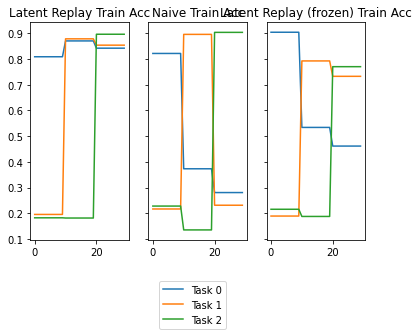

In [41]:
# JA: Next step - replace internal model.
# - model def                               ✅
# - frozen layer name                       ✅
# - batch renorm stuff...?                  ✅ (removed)

# JA: 2nd step
# - check replays work                      ✅
# - check replays work for subsequent exp's ✅
# - check latent replays work               ✅
# - add replay subsampling method           ✅

# JA: 3rd step
# - make GMM
# - add GMM to model replay storage 

fig, axes = plt.subplots(1, 3, sharey=True)
repeat_vals = 10

try:
    results_lat_replay_clean = utils.plot_results(
        results_lat_replay, "Latent Replay", axes[0], n_experiences, "acc", repeat_vals=repeat_vals
    )
except:
    pass
try:
    results_naive_clean = utils.plot_results(
        results_naive, "Naive", axes[1], n_experiences, "acc", repeat_vals=repeat_vals
    )
except:
    pass
try:
    results_lat_replay_2_clean = utils.plot_results(
        results_lat_replay_2, "Latent Replay (frozen)", axes[2], n_experiences, "acc", repeat_vals=repeat_vals
    )
except:
    pass

utils.plot_single_legend(fig)
